In [316]:
import pandas as pd
import numpy as np

boxrec_data = pd.read_csv('boxrec_tables.csv')
df = pd.DataFrame(boxrec_data)

In [317]:
df.replace(to_replace='None', value=np.nan, regex=True, inplace=True)

df.insert(3, 'div index', '')

div_list = ['heavy', 'cruiser', 'lightheavy', 'supermiddle', 'middle', 'superwelter', 'welter', 'superlight', 'light', 'feather', 'superbantam', 'bantam', 'superfly', 'fly', 'lightfly', 'minimum']

x = 0
for value in df['division']:
    df.at[x, 'div index'] = div_list.index(value)
    x += 1

In [318]:
ds = df.sort_values(by=['div index', 'division rating'], ascending=True)
# Can see age/height/reach need to be turned to float64s
cols_to_convert = ['age', 'height', 'reach']

for col in cols_to_convert:
    ds[col] = ds[col].astype(float)

In [319]:
dropped_missing_height_ds = ds.dropna(subset=['height'])
#Dropping missing height values gives 695 rows 
dropped_age_ds = dropped_missing_height_ds.dropna(subset=['age'])
#Dropping the missing age values from the new dataframe leaves 688 rows of data.
new_ds = dropped_age_ds

In [320]:
def replace_nan_with_mean(dataframe, column, grouping_column):
    dataframe[column] = dataframe.groupby(grouping_column)[column].transform(lambda x: x.fillna(round(x.mean(), 2)))

In [321]:
diff_reach = new_ds.reach - new_ds.height
new_ds.insert(12, 'diff reach', diff_reach)

replace_nan_with_mean(new_ds, 'diff reach', 'division')

C:\Users\smbal\AppData\Local\Temp\ipykernel_33788\2005571305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = dataframe.groupby(grouping_column)[column].transform(lambda x: x.fillna(round(x.mean(), 2)))


In [322]:
new_ds.reach.isnull().sum()

279

In [323]:
new_list = new_ds.reach.isnull().index
reach_min = new_ds.reach.min()

for x in new_list:
    if new_ds.reach[x] >= reach_min:
        pass
    else:
        new_ds.reach[x] = new_ds.height[x] + new_ds['diff reach'][x]

C:\Users\smbal\AppData\Local\Temp\ipykernel_33788\183722667.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_ds.reach[x] = new_ds.height[x] + new_ds['diff reach'][x]


In [324]:
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='height', ylabel='reach'>

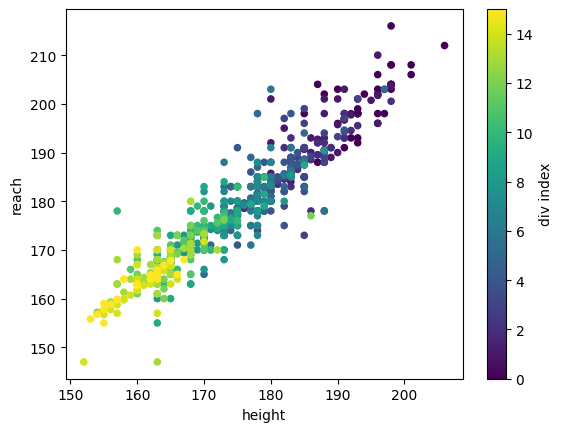

In [325]:
new_ds.plot.scatter(x='height', y='reach', c='div index', colormap='viridis')

Logical linear relationship between the division and a boxer's height and reach. The heavier the division, the greater the fighter's height or reach. There are some obvious outliers in the data too.

In [327]:
average_by_division = new_ds.groupby(['div index']).mean(numeric_only=True).round(2)
average_everything_numeric = new_ds.mean(numeric_only=True).round(2)


Text(0, 0.5, 'Average value')

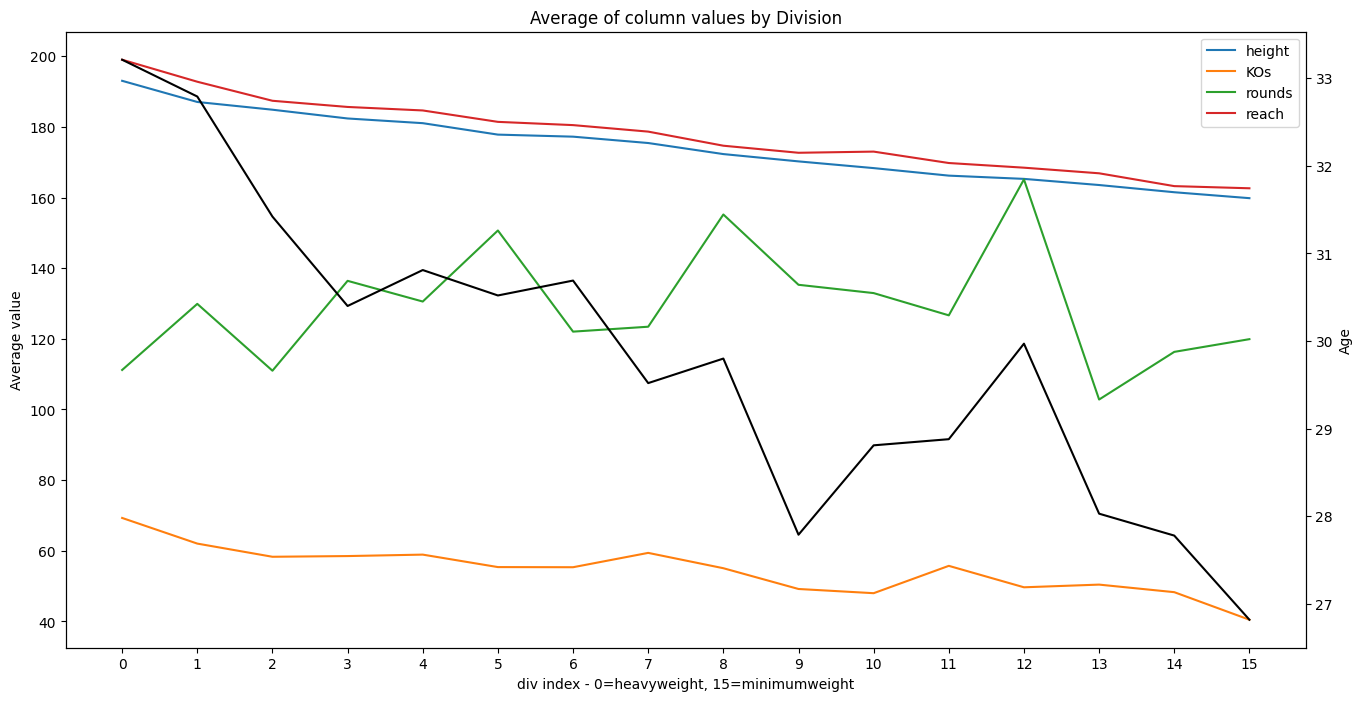

In [329]:
fig, ax = plt.subplots()

width = 16
height = 8
fig.set_size_inches(width, height)
ax.plot(average_by_division['height'], label='height')
ax.plot(average_by_division['KOs'], label='KOs')
ax.plot(average_by_division['rounds'], label='rounds')
ax.plot(average_by_division['reach'], label='reach')

ax2 = ax.twinx()
ax2.plot(average_by_division['age'], label='age', color='black')
ax2.set_ylabel('Age')
ax.legend()
ax.set_xticks(np.arange(0, 16, 1))
ax.set_title('Average of column values by Division')
ax.set_xlabel('div index - 0=heavyweight, 15=minimumweight')
ax.set_ylabel('Average value')

Line graph here shows the similar relationship between height and reach having a linear relationship to a boxer's weight division. The black line represents Age on the second-y axis, and shows an interesting relationship where the boxer's in heavier weight classes are on average older than those in lighter weight classes. This makes sense as lighter divisions rely more on athleticism than raw power. This is somewhat seen in the fact that KO's are downwards trending on a scale of heavy to light divisions in the above graph.

<AxesSubplot: >

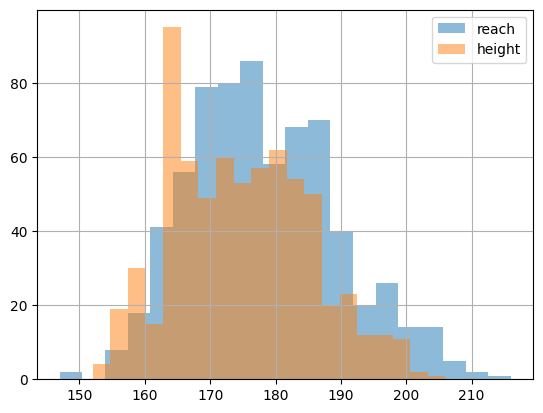

In [341]:
new_ds['reach'].hist(bins=20, alpha=0.5, legend=True)
new_ds['height'].hist(bins=20, alpha=0.5, legend=True)

We can see a relationship where a boxer's height generally tends to be greater than their height.

<AxesSubplot: >

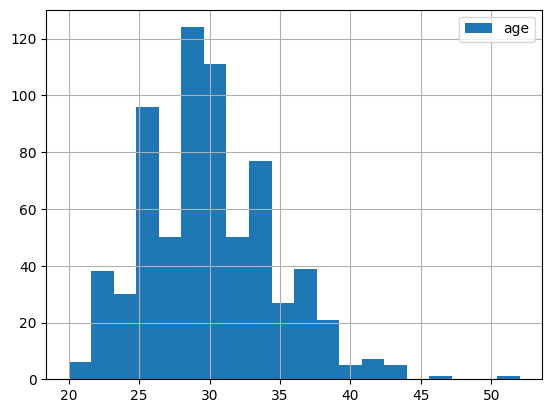

In [331]:
new_ds['age'].hist(bins=20, legend=True)

Boxer age is clearly right-skewed, which again makes logical sense as boxing is a highly anaerobic sport, meaning successful practioners are likely to be fighting in and around their prime-years of between 25-30 years of age, which can also be seen in the data.

In [342]:
#CLEANING REMAINING NULL VALUES
column_list = new_ds.columns

for x in column_list:
    if new_ds[x].isnull().sum() != 0:
        print(f'{x} null values: {new_ds[x].isnull().sum()}')
        # stance null values: 26
        # birth place null values: 28

stance_null = new_ds['stance'].isnull().index
birth_null = new_ds['birth place'].isnull().index
#7 birthplace nulls have no stance value, as there is no overlap and this isn't something that can be imputed, we are removing all nulls.

stance null values: 26
birth place null values: 28


In [343]:
# removing stance and birthplace null values... will first remove stance nulls as they are more important, and then remove birth place nulls.
dropping_stance_ds = new_ds.dropna(subset=['stance'])
clean_ds = dropping_stance_ds.dropna(subset=['birth place'])
# running null check
for x in column_list:
    if clean_ds[x].isnull().sum() != 0:
        print(f'{x} null values: {clean_ds[x].isnull().sum()}')

In [344]:
from datetime import datetime

dates = clean_ds.debut.index
for x in dates:
    clean_ds.debut[x] = datetime.strptime(clean_ds.debut[x], '%d/%m/%Y').date()

clean_ds.debut = pd.to_datetime(clean_ds.debut)

C:\Users\smbal\AppData\Local\Temp\ipykernel_33788\4188815707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ds.debut[x] = datetime.strptime(clean_ds.debut[x], '%d/%m/%Y').date()
C:\Users\smbal\AppData\Local\Temp\ipykernel_33788\4188815707.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ds.debut = pd.to_datetime(clean_ds.debut)


In [ ]:
clean_ds.dtypes

In [346]:
end_date = pd.to_datetime('2022/12/06')
days_active = end_date - clean_ds.debut

In [ ]:
clean_ds.insert(8, 'days active', days_active)
clean_ds['days active'] = clean_ds['days active'].astype(str)
clean_ds['days active'] = clean_ds['days active'].map(lambda x: x.rstrip(' days'))
clean_ds['days active'] = clean_ds['days active'].astype(int)

In [348]:
bout_data = pd.read_csv('bout_data.csv')
bd_df = df = pd.DataFrame(bout_data)

names_list = clean_ds['name'].to_list()

clean_name_list = list(dict.fromkeys(names_list))
print(len(clean_name_list))

638


In [ ]:
bd_df.columns

In [350]:
filtered_df_x = bd_df[bd_df['name'].isin(clean_name_list)]

grouped_df_x = filtered_df_x.groupby('name')[['opp_wins', 'opp_losses', 'opp_draws']].sum()

name_counts = filtered_df_x['name'].value_counts()

grouped_df_x = grouped_df_x.assign(w_minus_l = grouped_df_x['opp_wins'] - grouped_df_x['opp_losses'])
grouped_df_x = grouped_df_x.assign(opp_win_pct = round(((2 * grouped_df_x['opp_wins'] + grouped_df_x['opp_draws']) / (2 * (grouped_df_x['opp_wins'] + grouped_df_x['opp_losses'] + grouped_df_x['opp_draws']))),2))

In [351]:
clean_ds = clean_ds.merge(grouped_df_x, left_on='name', right_on='name')

In [352]:
preproc_ds = clean_ds

In [354]:
preproc_ds

,name,division rating,division,div index,bouts,rounds,KOs,debut,days active,age,...,wins,losses,draws,KO wins,KO losses,opp_wins,opp_losses,opp_draws,w_minus_l,opp_win_pct
0,Oleksandr Usyk,1,heavy,0,20,168,65.00,2013-12-14,3279,35.0,...,20,0,0,13,0,473,79,9,394,0.85
1,Anthony Joshua,2,heavy,0,27,136,81.48,2013-10-26,3328,33.0,...,24,3,0,22,1,672,141,11,531,0.82
2,Andy Ruiz,4,heavy,0,37,187,59.46,2009-06-26,4911,33.0,...,35,2,0,22,0,576,168,33,408,0.76
3,Dillian Whyte,5,heavy,0,31,170,61.29,2011-09-16,4099,35.0,...,28,3,0,19,3,567,291,35,276,0.65
4,Joe Joyce,6,heavy,0,15,74,93.33,2018-02-16,1754,37.0,...,15,0,0,14,0,340,55,6,285,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,Yuni Takada,43,minimum,15,20,104,20.00,2015-08-08,2677,24.0,...,9,8,3,4,4,126,50,4,76,0.71
633,Tatsuro Nakashima,46,minimum,15,15,70,46.67,2015-11-15,2578,28.0,...,11,3,1,7,2,76,50,8,26,0.60
634,Yuri Kanaya,49,minimum,15,3,17,0.00,2021-10-20,412,26.0,...,3,0,0,0,0,27,12,1,15,0.69
635,Sora Takeda,50,minimum,15,10,43,10.00,2017-08-27,1927,22.0,...,6,4,0,1,2,37,10,1,27,0.78


In [355]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

#perform label encoding on 'team' column
preproc_ds.stance= label_encoder.fit_transform(preproc_ds.stance)

In [356]:
preproc_ds = preproc_ds.drop('name', axis=1)
preproc_ds = preproc_ds.drop('division', axis=1)
preproc_ds = preproc_ds.drop('diff reach', axis=1)
preproc_ds = preproc_ds.drop('residence', axis=1)
preproc_ds = preproc_ds.drop('birth place', axis=1)
preproc_ds = preproc_ds.drop('debut', axis=1)
preproc_ds['div index'] = preproc_ds['div index'].astype(int)

In [357]:
preproc_ds.dtypes

division rating      int64
div index            int32
bouts                int64
rounds               int64
KOs                float64
days active          int32
age                float64
stance               int32
height             float64
reach              float64
wins                 int64
losses               int64
draws                int64
KO wins              int64
KO losses            int64
opp_wins             int64
opp_losses           int64
opp_draws            int64
w_minus_l            int64
opp_win_pct        float64
dtype: object

In [358]:
six_ds = preproc_ds[['height', 'reach', 'age', 'days active', 'div index', 'division rating']]


In [359]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [360]:
k = 6

0: [0.577, 0.627, 0.62, 0.648, 0.647, 0.65, 0.625, 0.637, 0.636]
1: [0.689, 0.713, 0.638, 0.616, 0.592, 0.56, 0.543, 0.49, 0.521]
2: [0.607, 0.522, 0.578, 0.6, 0.615, 0.627, 0.62, 0.628, 0.601]
3: [0.62, 0.573, 0.592, 0.626, 0.638, 0.657, 0.633, 0.57, 0.581]
4: [0.541, 0.581, 0.557, 0.602, 0.6, 0.582, 0.62, 0.61, 0.584]
5: [0.618, 0.651, 0.614, 0.618, 0.606, 0.625, 0.605, 0.642, 0.67]
6: [0.622, 0.557, 0.56, 0.56, 0.55, 0.553, 0.521, 0.529, 0.514]
7: [0.558, 0.563, 0.493, 0.535, 0.531, 0.559, 0.561, 0.549, 0.507]
8: [0.662, 0.706, 0.665, 0.619, 0.635, 0.584, 0.586, 0.571, 0.597]
9: [0.558, 0.577, 0.522, 0.558, 0.536, 0.586, 0.561, 0.548, 0.585]
10: [0.627, 0.671, 0.626, 0.645, 0.67, 0.663, 0.708, 0.706, 0.675]
11: [0.566, 0.606, 0.57, 0.56, 0.591, 0.621, 0.617, 0.606, 0.606]
12: [0.705, 0.676, 0.657, 0.658, 0.644, 0.61, 0.618, 0.626, 0.595]
13: [0.545, 0.561, 0.538, 0.591, 0.513, 0.562, 0.557, 0.529, 0.543]
14: [0.708, 0.56, 0.577, 0.586, 0.561, 0.621, 0.564, 0.559, 0.561]
15: [0.496, 

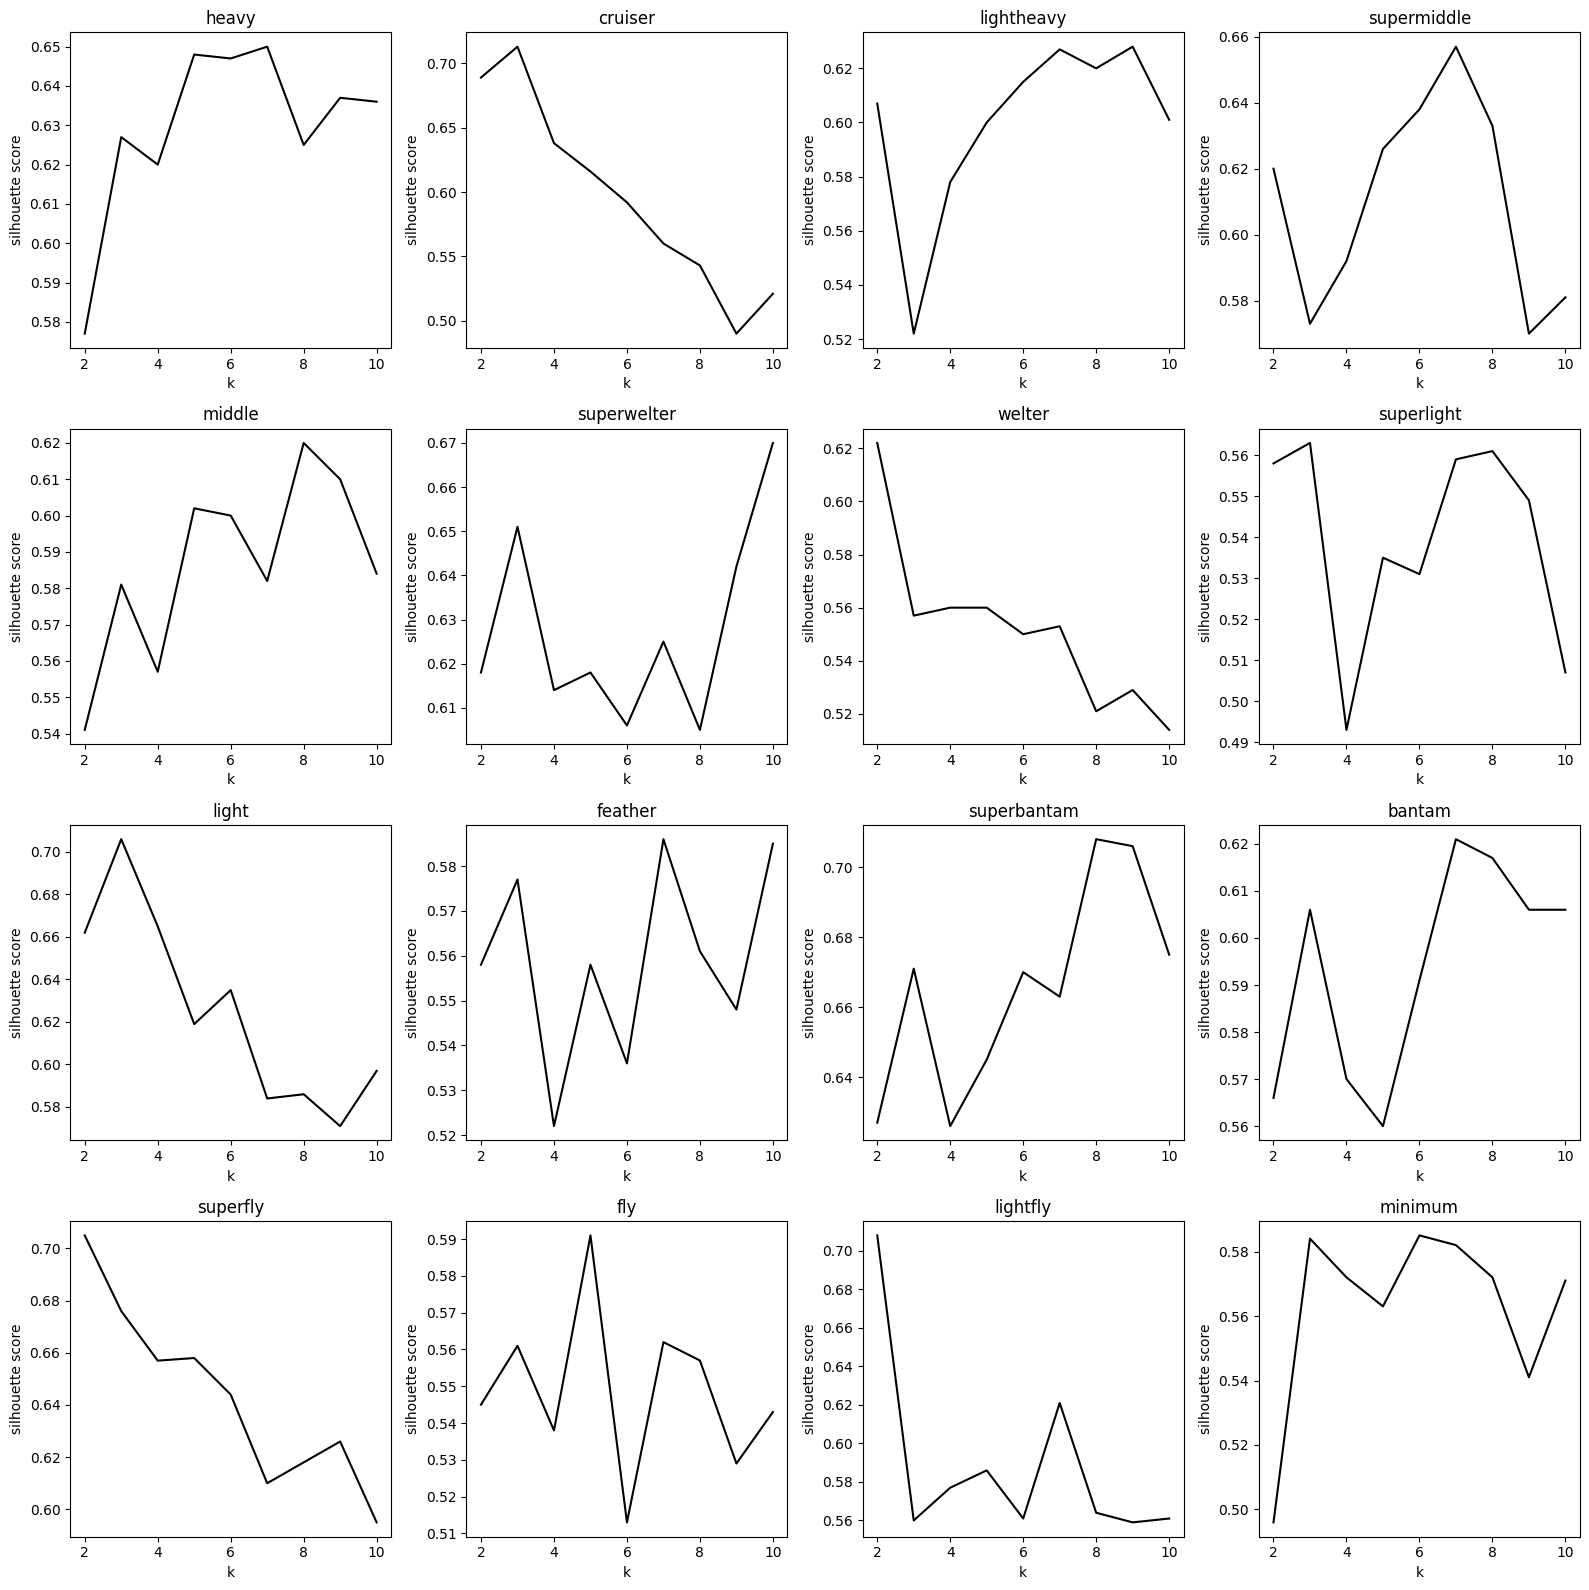

In [361]:
# Group the six_ds DataFrame by the div index column
grouped_df = six_ds.groupby('div index')

# Use the apply method to apply the k-means clustering algorithm to each group
grouped_df_clustered = grouped_df.apply(lambda group: KMeans(n_clusters=k).fit_predict(group))

# Create a figure with 16 subplots (one for each div index value)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Use a for loop to plot each group in a separate subplot
# Use a for loop to plot each group in a separate subplot
for i, (name, group) in enumerate(grouped_df):
    # Create an empty list to store the silhouette scores for this group
    silhouette_scores = []

    # Use a nested for loop to iterate over the range of k values from 2 to 8
    for k in range(2, 11):
        # Create a KMeans object
        model = KMeans(n_clusters=k)

        # Fit the model to the data in this group
        cluster_labels = model.fit_predict(group)

        # Calculate the silhouette score for this model
        score = silhouette_score(group, cluster_labels)

        # Append the silhouette score to the list
        silhouette_scores.append(round(score, 3))
    print(f'{name}: {silhouette_scores}')

    # Use the plot method to plot the silhouette scores for this group
    axes[i // 4, i % 4].plot(range(2, 11), silhouette_scores, c='black')

    # Add x and y labels and a title to the subplot
    axes[i // 4, i % 4].set_xlabel('k')
    axes[i // 4, i % 4].set_ylabel('silhouette score')
    axes[i // 4, i % 4].set_title(f'{div_list[name]}')

# Adjust the spacing between the subplots
fig.tight_layout()

In [362]:
k = 6

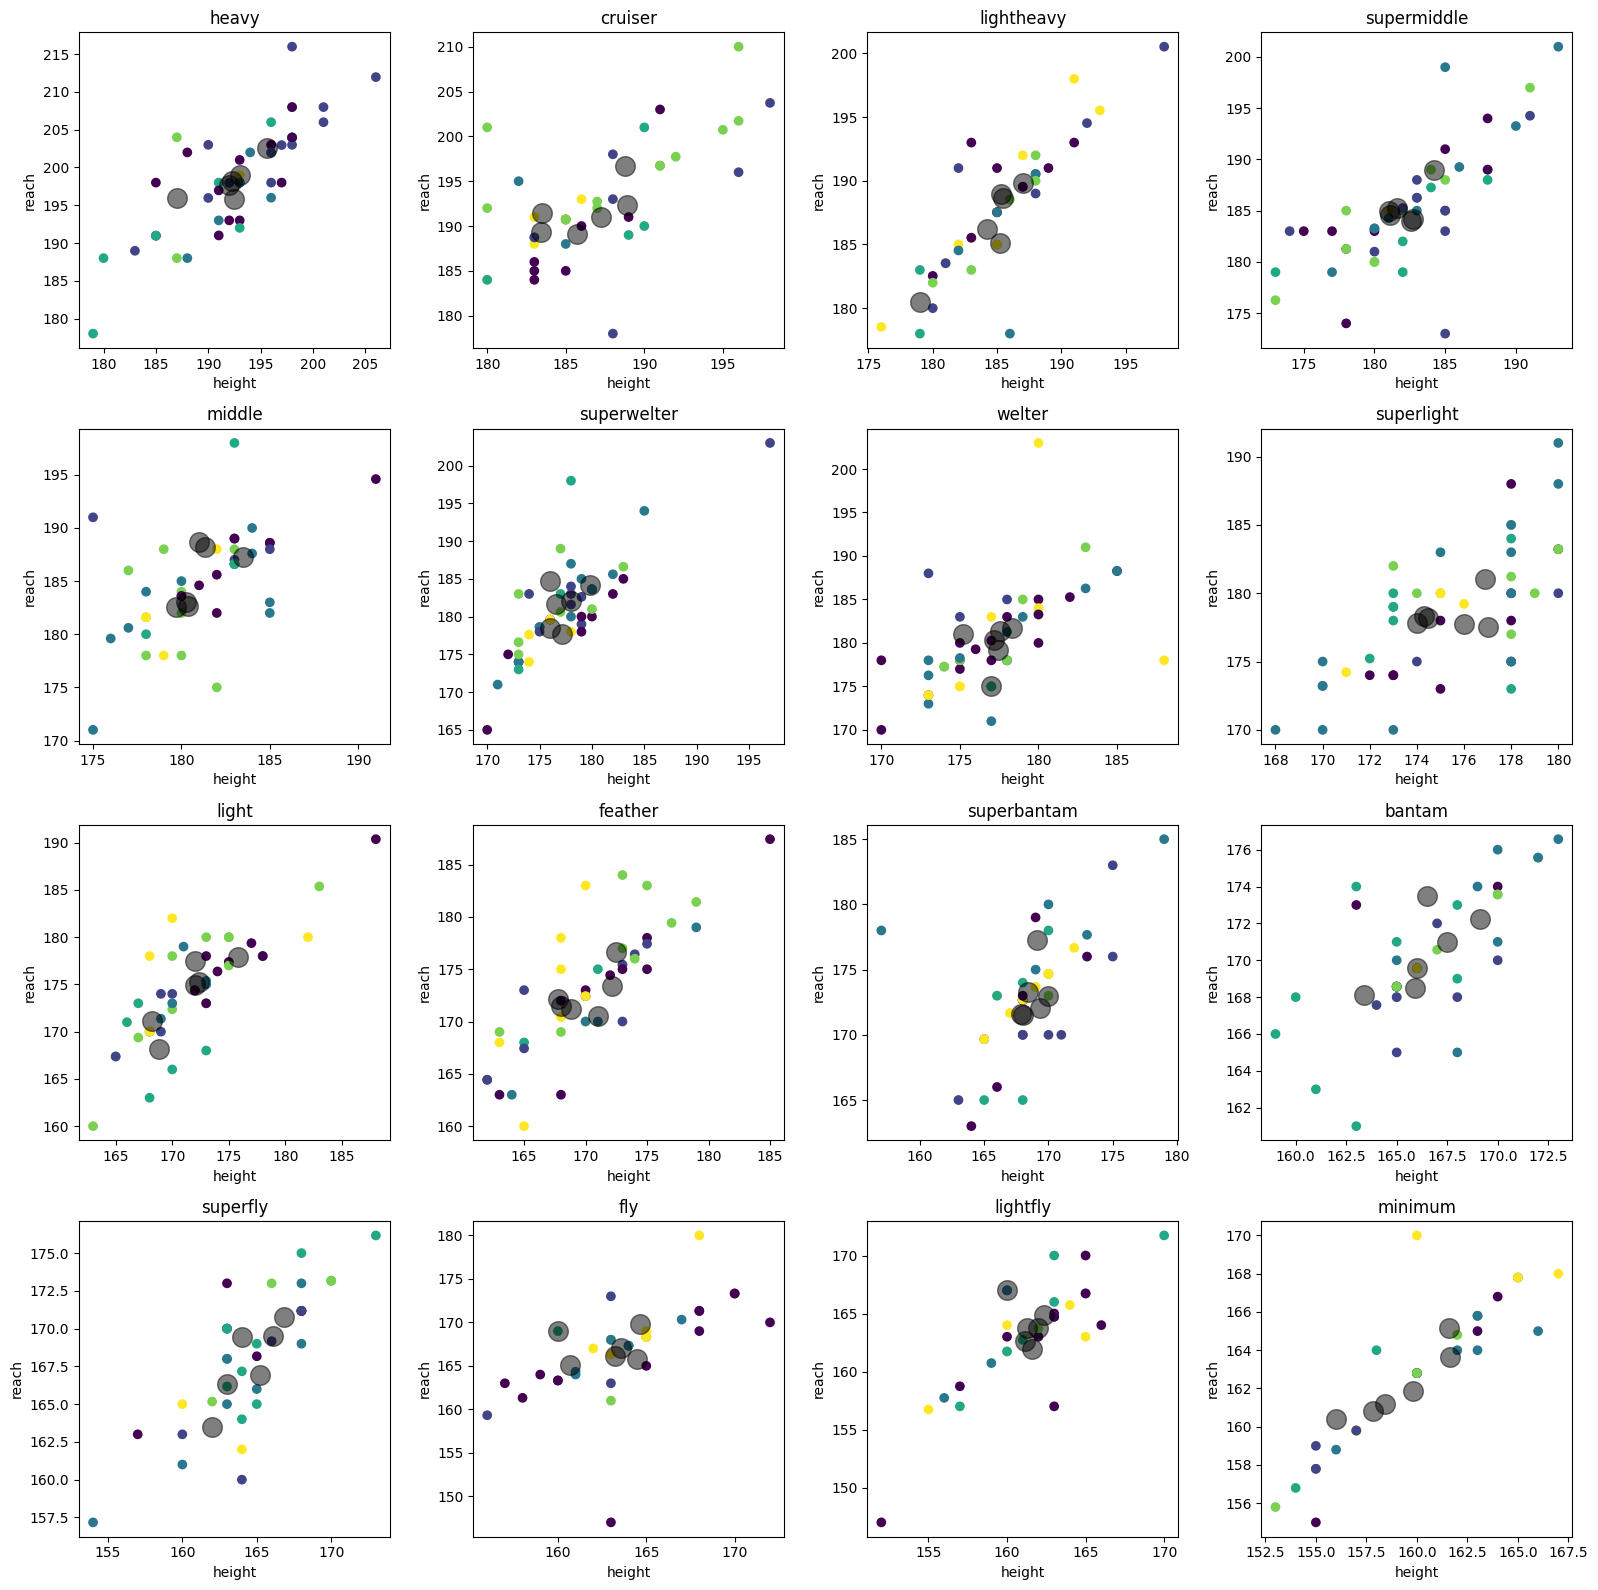

In [363]:
grouped_df = six_ds.groupby('div index')

# Create a figure with 16 subplots (one for each div index value)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Use a for loop to plot each group in a separate subplot
for i, (name, group) in enumerate(grouped_df):
    # Create a KMeans object
    model = KMeans(n_clusters=k)
    
    # Fit the model to the data in this group
    cluster_labels = model.fit_predict(group)
    
    # Use the scatter method to plot the data points
    axes[i // 4, i % 4].scatter(group['height'], group['reach'], c=cluster_labels, cmap='viridis')

    # Use the scatter method again to plot the cluster centers
    cluster_centers = model.cluster_centers_
    axes[i // 4, i % 4].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=200, alpha=0.5)
    
    # Add x and y labels and a title to the subplot
    axes[i // 4, i % 4].set_xlabel('height')
    axes[i // 4, i % 4].set_ylabel('reach')
    axes[i // 4, i % 4].set_title(f'{div_list[name]}')

# Adjust the spacing between the subplots
fig.tight_layout()

from the K means clustering visualisations we can see an interesting 

In [364]:
grouped_df['height', 'age'].describe()

C:\Users\smbal\AppData\Local\Temp\ipykernel_33788\2799942490.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df['height', 'age'].describe()


height                                                            \
           count        mean       std    min     25%    50%    75%    max   
div index                                                                    
0           47.0  193.042553  5.563692  179.0  190.50  193.0  197.5  206.0   
1           39.0  187.128205  4.878414  180.0  183.00  186.0  190.5  198.0   
2           39.0  185.153846  4.386213  176.0  182.00  185.0  188.0  198.0   
3           44.0  182.477273  4.790925  173.0  180.00  182.5  185.0  193.0   
4           40.0  181.200000  3.298795  175.0  178.75  182.0  183.0  191.0   
5           46.0  177.652174  4.483141  170.0  174.25  178.0  180.0  197.0   
6           45.0  177.244444  3.862145  170.0  175.00  177.0  180.0  188.0   
7           43.0  175.325581  3.350344  168.0  173.00  175.0  178.0  180.0   
8           41.0  172.024390  5.027364  163.0  169.00  172.0  175.0  188.0   
9           42.0  170.357143  5.078993  162.0  168.00  170.0  173.0  185.0   
10          40.0  168.600000  3.628943  157.0  167.75  168.0  170.0  179.0   
11          37.0  166.432432  3.287523  159.0  165.00  166.0  169.0  173.0   
12          36.0  164.722222  3.776704  154.0  163.00  164.5  168.0  173.0   
13          34.0  163.705882  3.745943  156.0  161.25  163.0  165.0  172.0   
14          31.0  161.548387  3.613297  152.0  160.00  163.0  163.0  170.0   
15          33.0  159.818182  3.778678  153.0  157.00  160.0  163.0  167.0   

            age                                                       
          count       mean       std   min    25%   50%    75%   max  
div index                                                             
0          47.0  33.212766  4.713238  23.0  30.00  33.0  35.50  43.0  
1          39.0  32.717949  4.701336  24.0  30.00  32.0  34.50  52.0  
2          39.0  31.512821  3.331443  24.0  29.50  31.0  33.00  39.0  
3          44.0  30.386364  4.779880  21.0  27.00  30.0  33.25  43.0  
4          40.0  30.675000  4.626498  23.0  27.75  30.0  33.00  43.0  
5          46.0  30.434783  4.047782  21.0  27.00  31.0  33.75  37.0  
6          45.0  30.800000  3.876503  23.0  28.00  31.0  34.00  38.0  
7          43.0  29.813953  3.762318  23.0  27.00  30.0  33.00  39.0  
8          41.0  30.048780  4.908927  23.0  27.00  29.0  33.00  46.0  
9          42.0  27.976190  3.828571  21.0  25.00  28.0  30.75  38.0  
10         40.0  28.925000  4.346454  22.0  26.00  28.0  32.00  43.0  
11         37.0  29.243243  4.374201  22.0  26.00  29.0  31.00  42.0  
12         36.0  30.138889  4.715644  22.0  26.75  30.5  34.00  40.0  
13         34.0  28.352941  4.457764  23.0  25.00  27.0  31.50  40.0  
14         31.0  27.677419  4.407472  20.0  25.50  27.0  29.50  42.0  
15         33.0  26.787879  4.083179  20.0  24.00  26.0  28.00  37.0

In [365]:
for name, group in grouped_df:
    height_q1 = group['height'].quantile(0.25)
    height_q3 = group['height'].quantile(0.75)
    age_q1 = group['age'].quantile(0.25)
    age_q3 = group['age'].quantile(0.75)

    height_IQR = height_q3 - height_q1
    age_IQR = age_q3 - age_q1

    height_outliers = group[( (group['height'] < (height_q1 - 1.5*height_IQR)) | (group['height'] > (height_q3 + 1.5*height_IQR)) )]
    age_outliers = group[( (group['age'] < (age_q1 - 1.5*age_IQR)) | (group['age'] > (age_q3 + 1.5*age_IQR)) )]
  
    # Count the number of outliers in the 'height' and 'age' columns
    height_outlier_count = height_outliers.count()
    age_outlier_count = age_outliers.count()
    
    print(f'{div_list[name]}: height outliers: {height_outlier_count.height} - age outliers: {age_outlier_count.age}')

heavy: height outliers: 1 - age outliers: 0
cruiser: height outliers: 0 - age outliers: 1
lightheavy: height outliers: 1 - age outliers: 3
supermiddle: height outliers: 1 - age outliers: 1
middle: height outliers: 1 - age outliers: 1
superwelter: height outliers: 1 - age outliers: 0
welter: height outliers: 1 - age outliers: 0
superlight: height outliers: 0 - age outliers: 0
light: height outliers: 1 - age outliers: 1
feather: height outliers: 1 - age outliers: 0
superbantam: height outliers: 6 - age outliers: 1
bantam: height outliers: 0 - age outliers: 3
superfly: height outliers: 1 - age outliers: 0
fly: height outliers: 1 - age outliers: 0
lightfly: height outliers: 3 - age outliers: 1
minimum: height outliers: 0 - age outliers: 2


In [366]:
X = preproc_ds[['age', 'bouts', 'height', 'reach', 'stance', 'wins', 'losses', 'KO wins', 'days active', 'w_minus_l','opp_win_pct']]

X

,age,bouts,height,reach,stance,wins,losses,KO wins,days active,w_minus_l,opp_win_pct
0,35.0,20,191.0,198.0,1,20,0,13,3279,394,0.85
1,33.0,27,198.0,208.0,0,24,3,22,3328,531,0.82
2,33.0,37,188.0,188.0,0,35,2,22,4911,408,0.76
3,35.0,31,193.0,198.0,0,28,3,19,4099,276,0.65
4,37.0,15,198.0,203.0,0,15,0,14,1754,285,0.86
...,...,...,...,...,...,...,...,...,...,...,...
632,24.0,20,156.0,158.8,0,9,8,4,2677,76,0.71
633,28.0,15,165.0,167.8,0,11,3,7,2578,26,0.60
634,26.0,3,155.0,157.8,0,3,0,0,412,15,0.69
635,22.0,10,162.0,164.8,1,6,4,1,1927,27,0.78


In [367]:
kmeans = KMeans(n_clusters=16, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=16, random_state=42)

In [368]:
# Predict the cluster labels for each boxer
cluster_labels = kmeans.predict(X)

In [ ]:
# Create a figure with 16 subplots (one for each cluster)
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the clusters
for i in range(16):
    # Select the data for the current cluster
    x = preproc_ds.loc[cluster_labels == i, "height"]
    y = preproc_ds.loc[cluster_labels == i, "reach"]

    # Create a scatter plot for the current cluster
    axes[i // 4, i % 4].scatter(x, y, c='black', alpha=0.5, label=f"Cluster {i}")
    axes[i // 4, i % 4].set_xlabel("Height")
    axes[i // 4, i % 4].set_ylabel("Reach")
    axes[i // 4, i % 4].legend()

fig.tight_layout()

In [369]:
clustered_df = preproc_ds

In [370]:
clustered_df['cluster label'] = cluster_labels

In [375]:
clustered_df.columns

Index(['division rating', 'div index', 'bouts', 'rounds', 'KOs', 'days active',
       'age', 'stance', 'height', 'reach', 'wins', 'losses', 'draws',
       'KO wins', 'KO losses', 'opp_wins', 'opp_losses', 'opp_draws',
       'w_minus_l', 'opp_win_pct', 'cluster label'],
      dtype='object')

In [390]:
clustered_df

,division rating,div index,bouts,rounds,KOs,days active,age,stance,height,reach,...,losses,draws,KO wins,KO losses,opp_wins,opp_losses,opp_draws,w_minus_l,opp_win_pct,cluster label
0,1,0,20,168,65.00,3279,35.0,1,191.0,198.0,...,0,0,13,0,473,79,9,394,0.85,3
1,2,0,27,136,81.48,3328,33.0,0,198.0,208.0,...,3,0,22,1,672,141,11,531,0.82,3
2,4,0,37,187,59.46,4911,33.0,0,188.0,188.0,...,2,0,22,0,576,168,33,408,0.76,1
3,5,0,31,170,61.29,4099,35.0,0,193.0,198.0,...,3,0,19,3,567,291,35,276,0.65,12
4,6,0,15,74,93.33,1754,37.0,0,198.0,203.0,...,0,0,14,0,340,55,6,285,0.86,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,43,15,20,104,20.00,2677,24.0,0,156.0,158.8,...,8,3,4,4,126,50,4,76,0.71,15
633,46,15,15,70,46.67,2578,28.0,0,165.0,167.8,...,3,1,7,2,76,50,8,26,0.60,15
634,49,15,3,17,0.00,412,26.0,0,155.0,157.8,...,0,0,0,0,27,12,1,15,0.69,13
635,50,15,10,43,10.00,1927,22.0,1,162.0,164.8,...,4,0,1,2,37,10,1,27,0.78,7


<AxesSubplot: xlabel='w_minus_l', ylabel='rounds'>

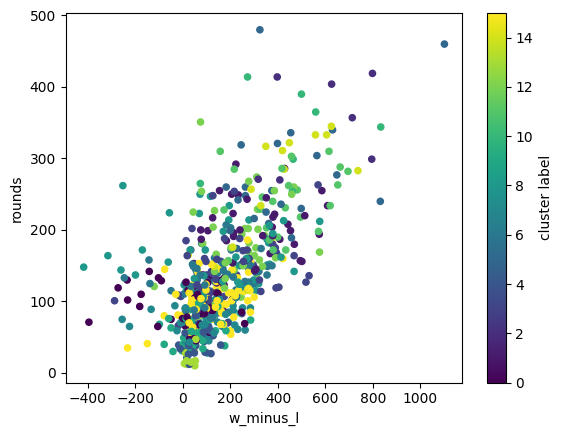

In [380]:
clustered_df.plot.scatter(x='w_minus_l', y='rounds', c='cluster label', colormap='viridis')

In [381]:
division_index = 10
boxer_x_rating = 1
boxer_y_rating = 3

# Selct the rows corresponding to boxer X and
boxer_x_row = clustered_df.loc[(clustered_df["div index"] == division_index) & (clustered_df["division rating"] == boxer_x_rating)]
boxer_y_row = clustered_df.loc[(clustered_df["div index"] == division_index) & (clustered_df["division rating"] == boxer_y_rating)]

# Get the indices of the rows
boxer_x_index = boxer_x_row.index[0]
boxer_y_index = boxer_y_row.index[0]

# Get the cluster labels for each boxer
boxer_x_cluster = clustered_df.loc[boxer_x_index, "cluster label"]
boxer_y_cluster = clustered_df.loc[boxer_y_index, "cluster label"]

# Get the number of bouts fought by each boxer
boxer_x_bouts = clustered_df.loc[boxer_x_index, "bouts"]
boxer_y_bouts = clustered_df.loc[boxer_y_index, "bouts"]

# Calculate the weighted average of the cluster labels
weighted_average = (boxer_x_cluster * boxer_x_bouts + boxer_y_cluster * boxer_y_bouts) / (boxer_x_bouts + boxer_y_bouts)

In [ ]:
print(f'FIGHTERS ARE IN THE {div_list[division_index].upper()}WEIGHT DIVISION.\n')
print(f'{clean_ds.name[boxer_x_index]} - Cluster #{boxer_x_cluster}')
print(f'{clean_ds.name[boxer_y_index]} - Cluster #{boxer_y_cluster}\n')

print('CLUSTER PREDICTION METHOD')
# Predict the outcome of the bout
if boxer_x_cluster > boxer_y_cluster:
  print(f'{clean_ds.name[boxer_x_index]} is predicted to win the bout.')
elif boxer_y_cluster > boxer_x_cluster:
  print(f'{clean_ds.name[boxer_y_index]} is predicted to win the bout.')
else:
  print("The outcome of the bout is uncertain.")

print('\nWEIGHTED AVERAGE METHOD')
print(f'wavg: {weighted_average}')
if weighted_average >= 2.5:
  print(f'{clean_ds.name[boxer_x_index]} is predicted to win the bout.')
elif weighted_average < 2.5:
  print(f'{clean_ds.name[boxer_y_index]} is predicted to win the bout.')
else:
  print("The outcome of the bout is uncertain.")